# OPTIMIZATION FOR MACHINE LEARNING
---
- KOUGOUM MOKO MANI Marilene
---

**M2MO : STOCHASTIC MODELLING, FINANCE AND DATA SCIENCE**

---

---

In [89]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import time

---

##   I. FIRST ORDER METHOD : NESTEROV WITH AND WITHOUT SPEED RESTART
---

### CONTEXT



---


In the field of numerical optimization, the gradient descent algorithm is a widely used first-order method and has been the main focus of the first part of this course. We have studied its properties, particularly its convergence rate, depending on the regularity of the objective function.

The Nesterov accelerated gradient algorithm also belongs to the family of first-order methods. It is an improvement of the classical gradient descent that aims to accelerate convergence and approach the optimal convergence rates theoretically achievable by first-order algorithms, as established in the literature (Nemirovski & Yudin, 1983; Nesterov's Book ).


In this first part of our project, we will implement different variants of Nesterov’s algorithm and apply them to a dataset in order to analyze their behavior and performance.

---

###   I.1. Implementation of Nesterov accelerated gradient method with speed restart and Nesterov accelerated gradient method with vanishing friction (without restart),(b = 3).

---

#####   **Nesterov with vanishing friction : Presentation of the method**

---

This variant of the **Nesterov Accelerated Gradient (NAG)** introduces a time-varying momentum to **model** a system with vanishing friction.  
It follows:

$$
\begin{aligned}
y_k &= x_k + \beta_{k-1}(x_k - x_{k-1}),\\
x_{k+1} &= y_k - \eta \nabla f(y_k).
\end{aligned}
$$

with $\beta_{k} = 1 - \frac{b}{k}$.

It approximates the continuous-time dynamic:

$$
\ddot{x}(t) + \frac{b}{t}\dot{x}(t) + \nabla f(x(t)) = 0.
$$

For the case **$b = 3$** implemented here, it was stated in the course that:
- for a **convex and differentiable** function, the convergence rate is $O(1/k^2)$;
- for a **strongly convex** function, the rate improves to $O(1/k^3)$.


---


#####   **Nesterov with vanishing friction : Code implemented  (see in the notebook)**

---

In [90]:
def nesterov_vanishing_friction(f, x0, steps=2000, lr=1e-3, b=3.0):
    x_prev = x0.clone().detach()
    x = x0.clone().detach()
    x.requires_grad_(True)

    values = []
    path = []

    for k in range(1, steps+1):
        beta = 1.0 - b/k
        y = x + beta * (x - x_prev)
        y.requires_grad_(True)

        loss = f(y)
        grad = torch.autograd.grad(loss, y)[0]

        with torch.no_grad():
            x_next = y - lr * grad

        values.append(loss.item())
        path.append(x_next.detach().clone())
        x_prev = x.clone().detach()
        x = x_next.clone().detach()
        x.requires_grad_(True)

    return x, values, path



---

#####   **Nesterov accelerated gradient method with speed restart : Preentation of the method**

---

### **Nesterov Accelerated Gradient with Speed Restart**

Although in the **convex case** the Nesterov method improves the convergence rate compared to classical gradient descent, in the **strongly convex case**, the convergence remains of order $O(1/k^3)$ , which is **less satisfactory** than the **linear rate** obtained with gradient descent.  

This can be explained by the fact that, in the **vanishing friction** version, the decreasing damping term may cause **oscillations** near the minimum, which slow down convergence.  

To address this issue, a variant called **Speed Restart** is introduced. The idea is to **reset the momentum** whenever the update speed decreases, according to the condition:  

$
\|x_{k+1} - x_k\| < \|x_k - x_{k-1}\|.
$


When this condition is satisfied, the algorithm **restarts with zero momentum**, improving stability and often leading to **faster  convergence**.  
However, it is important to note that **no theoretical guarantee** for the algorithmic version of speed restart.


---

#####   **Nesterov accelerated gradient method with speed restart : Implementation of the method (see in the notebook)**

---

In [91]:
def nesterov_speed_restart(f, x0, steps=2000, lr=1e-3, b=4.0, kmin=5):
    x_prev = x0.clone().detach()
    x = x0.clone().detach()
    x.requires_grad_(True)

    values = []
    path = []
    j = 0

    for k in range(steps):
        beta = j / (j + b) if j > 0 else 0.0

        y = x + beta * (x - x_prev)
        y.requires_grad_(True)

        loss = f(y)
        grad = torch.autograd.grad(loss, y)[0]

        with torch.no_grad():
            x_next = y - lr * grad

        values.append(loss.item())
        path.append(x_next.detach().clone())

        if k >= 2:
            speed_now = torch.norm(x_next - x)
            speed_prev = torch.norm(x - x_prev)
            if speed_now < speed_prev and j >= kmin:
                j = 0
            else:
                j += 1
        else:
            j += 1

        x_prev = x.clone().detach()
        x = x_next.clone().detach()
        x.requires_grad_(True)

    return x, values, path

---

###   I.2.  Comparison of both algorithms on the Rosenbrock function in dimension 2


---

##### Exploratory Analysis of the Rosenbrock Function

Before comparing the performance of the two optimization algorithms, we first analyze the **Rosenbrock function** that we want to minimize.

The Rosenbrock function, also known as the **banana function**, is defined in dimension 2 as:

$$
f(x, y) = (1 - x)^2 + 100(y - x^2)^2.
$$

It has a **global minimum** at $(x^*, y^*) = (1, 1)$ where $f(x^*, y^*) = 0$.

This function is smooth but **non-convex** (which places it outside the theoretical guarantees discussed in the course and for the optimization methods studied), with a narrow and curved valley that makes it challenging for gradient-based algorithms.
We visualize it below to better understand its landscape and the difficulty it poses for optimization methods.

---


In [92]:
def rosenbrock(x, y):
    return (1 - x)**2 + 100 * (y - x**2)**2

# Create a grid
x_vals = np.linspace(-2, 2, 200)
y_vals = np.linspace(-1, 3, 200)
X, Y = np.meshgrid(x_vals, y_vals)
Z = rosenbrock(X, Y)

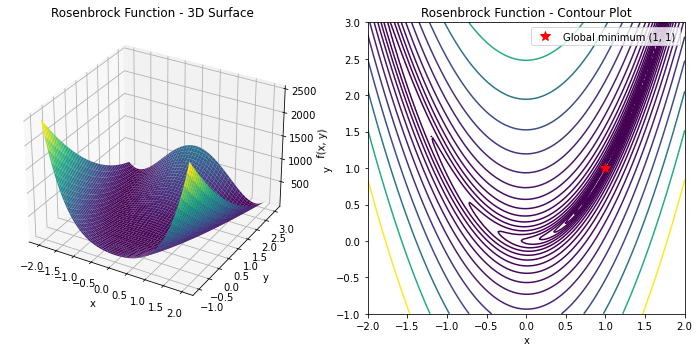

In [93]:
# --- 3D surface plot ---
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
ax.set_title("Rosenbrock Function - 3D Surface")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x, y)')

# --- Contour plot ---
ax2 = fig.add_subplot(1, 2, 2)
contours = ax2.contour(X, Y, Z, levels=np.logspace(-1, 3, 20), cmap='viridis')
ax2.set_title("Rosenbrock Function - Contour Plot")
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.plot(1, 1, 'r*', markersize=10, label='Global minimum (1, 1)')
ax2.legend()

plt.tight_layout()
plt.show()

---

As shown in the figure, the Rosenbrock function forms a narrow, elongated, and curved valley leading to the global minimum at (1, 1).

On the sides of the valley, the slopes are very steep, meaning that the gradient takes large values.
In this case, if the learning rate is too high, these large gradient values can cause first-order algorithms to overshoot the valley and jump from one side to the other without stabilizing near the minimum; resulting in oscillations.

Conversely, at the bottom of the valley, the slopes become very flat, so the gradient is almost zero.
The updates then become extremely small, leading to very slow convergence.

These behaviors, typical of first-order methods (such as gradient descent and Nesterov variants), make the Rosenbrock function particularly challenging to optimize.
It therefore serves as an good benchmark for evaluating the convergence speed and stability of such algorithms.

---

##### Test of the algorithms on a given initialization

---

In [94]:
def rosenbrock_torch(x):
    return (1 - x[0])**2 + 100 * (x[1] - x[0]**2)**2

# Initialization
x0 = torch.tensor([2.0, 2.0], dtype=torch.float32)

# Execution of methods
x_vf, values_vf, path_vf = nesterov_vanishing_friction(rosenbrock_torch, x0, steps=2000, lr=1e-3, b=3.0)
x_sr, values_sr, path_sr = nesterov_speed_restart(rosenbrock_torch, x0, steps=2000, lr=1e-3, b=3.0, kmin=5)

print("Result with Vanishing Friction algoritm (without speed restart) :", x_vf)
print("Résult with Speed Restart   :", x_sr)

Result with Vanishing Friction algoritm (without speed restart) : tensor([1.0004, 1.0007], requires_grad=True)
Résult with Speed Restart   : tensor([1.0000, 0.9999], requires_grad=True)


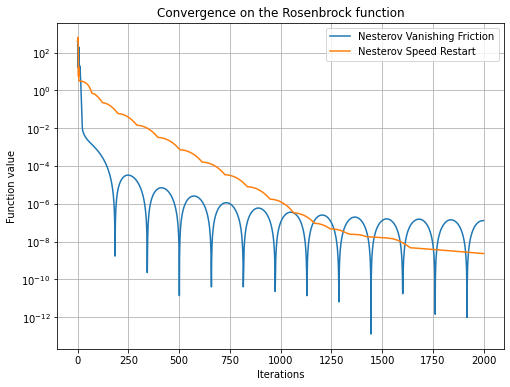

In [95]:
# --- Convergence curves ---
plt.figure(figsize=(8,6))
plt.plot(values_vf, label='Nesterov Vanishing Friction')
plt.plot(values_sr, label='Nesterov Speed Restart')
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Function value')
plt.title('Convergence on the Rosenbrock function')
plt.legend()
plt.grid(True)
plt.show()


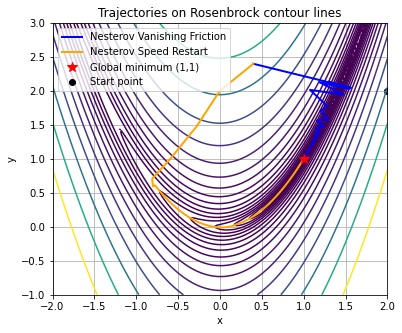

In [96]:
# --- Trajectories of both algorithms on Rosenbrock contour lines ---
path_vf = np.array([[p[0].item(), p[1].item()] for p in path_vf])
path_sr = np.array([[p[0].item(), p[1].item()] for p in path_sr])

plt.figure(figsize=(6,5))
plt.contour(X, Y, Z, levels=np.logspace(-1, 3, 20), cmap='viridis')
plt.plot(path_vf[:,0], path_vf[:,1], 'b-', lw=2, label='Nesterov Vanishing Friction')
plt.plot(path_sr[:,0], path_sr[:,1], 'orange', lw=2, label='Nesterov Speed Restart')
plt.scatter(2, 2, color='black', label='Start point')
plt.plot(1, 1, 'r*', markersize=10, label='Global minimum (1,1)')
plt.xlabel('x'); plt.ylabel('y')
plt.title('Trajectories on Rosenbrock contour lines')
plt.legend(); plt.grid(True)
plt.show()


---

Both algorithms converge toward the global minimum $ (1,1) $.  
The **Vanishing Friction** method reaches $ [1.0004,\, 1.0007] $ with an oscillatory trajectory,  
while the **Speed Restart** variant reaches $ [1.0000,\, 0.9999] $ with a smoother trajectory.  

These results confirm the correct implementation of both methods and their expected behaviors. 
They will be compared in more detail below.

---

##### Procedure of comparison

---

To compare both methods, it is important to limit experimental bias.  
Thus, for each comparison criterion, both algorithms are evaluated under the **same conditions** *(fixed learning rate and random seed)* to ensure reproducibility and fairness in testing.

- **Sensitivity to initialization:**  
  The Rosenbrock function exhibits steep slopes and a narrow valley.  
  The algorithms are initialized at different locations: on a steep slope, inside the valley, and on a flatter region.  
  For each configuration, we compute the **empirical mean** of  
  $|F(x_k) - F^*|$  and  $ \|x_k - x^*\|$  at the terminal points, i.e., the final solutions proposed by each algorithm.  
  These quantities allow us to compare their ability to approach the global minimum.

- **Convergence speed:**  
  For the same initialization points, we measure the **number of iterations required** for  
  $|F(x_k) - F^*|$  and  $ \|x_k - x^*\|$  to reach **1% of their initial value**.  
  In addition, we record the **total execution time** needed to achieve the same threshold,  
  which helps differentiate algorithms that converge quickly in iterations but are computationally expensive.  
  The results are then **averaged** for each method to obtain a synthetic measure of convergence speed.

The **convergence stability** is not investigated here, since the **Speed Restart** method is designed to reduce oscillations in the loss function.  

It is important to note that these results are **dependent on the chosen experimental conditions**.


---

In [97]:
def evaluate_algorithms(inits, steps=2000, lr=1e-3, b=3.0, tol_frac=0.01):
    results = {"vf": {}, "sr": {}}

    for name, p in inits.items():
        x0 = torch.tensor(p, dtype=torch.float32)
        f0 = rosenbrock_torch(x0).item()
        target_f = f_star + tol_frac * abs(f0 - f_star)

        # --- Vanishing friction ---
        start = time.time()
        x_vf, values_vf, _ = nesterov_vanishing_friction(rosenbrock_torch, x0, steps, lr, b)
        t_vf = time.time() - start
        f_end_vf = rosenbrock_torch(x_vf).item()
        dist_vf = torch.norm(x_vf - x_star).item()
        iter_vf = next((i for i, v in enumerate(values_vf) if v <= target_f), steps)

        # --- Speed restart ---
        start = time.time()
        x_sr, values_sr, _ = nesterov_speed_restart(rosenbrock_torch, x0, steps, lr, b, kmin=5)
        t_sr = time.time() - start
        f_end_sr = rosenbrock_torch(x_sr).item()
        dist_sr = torch.norm(x_sr - x_star).item()
        iter_sr = next((i for i, v in enumerate(values_sr) if v <= target_f), steps)

        # --- Store results ---
        results["vf"][name] = {
            "init": p,
            "|F-F*|": abs(f_end_vf - f_star),
            "||x-x*||": dist_vf,
            "iters_30%": iter_vf,
            "time": t_vf
        }
        results["sr"][name] = {
            "init": p,
            "|F-F*|": abs(f_end_sr - f_star),
            "||x-x*||": dist_sr,
            "iters_30%": iter_sr,
            "time": t_sr
        }

        # --- Print results ---
        print(f"\n--- Initialization: {name} ({p}) ---")
        print(f"Vanishing Friction → |F-F*|={results['vf'][name]['|F-F*|']:.2e}, "
              f"||x-x*||={results['vf'][name]['||x-x*||']:.2e}, "
              f"iters={iter_vf}, time={t_vf:.3f}s")
        print(f"Speed Restart      → |F-F*|={results['sr'][name]['|F-F*|']:.2e}, "
              f"||x-x*||={results['sr'][name]['||x-x*||']:.2e}, "
              f"iters={iter_sr}, time={t_sr:.3f}s")

    return results


In [98]:
x_star = torch.tensor([1.0, 1.0])
f_star = 0.0

# ---  diverse initializations (slopes, valley, flat areas) ---
inits = {
    "steep_slope_1": [2.0, 2.0],
    "steep_slope_2": [-1.5, 1.0],
    "valley_1": [0.8, 1.2],
    "valley_2": [1.2, 0.8],
    "flat_region": [-1.0, -1.0],
    "transition_zone": [0.5, 0.5]
}


In [99]:
# --- Run experiment ---
results = evaluate_algorithms(inits)


--- Initialization: steep_slope_1 ([2.0, 2.0]) ---
Vanishing Friction → |F-F*|=1.28e-07, ||x-x*||=7.99e-04, iters=15, time=0.543s
Speed Restart      → |F-F*|=2.30e-09, ||x-x*||=1.07e-04, iters=6, time=0.652s

--- Initialization: steep_slope_2 ([-1.5, 1.0]) ---
Vanishing Friction → |F-F*|=1.11e-05, ||x-x*||=7.44e-03, iters=74, time=0.516s
Speed Restart      → |F-F*|=1.92e-09, ||x-x*||=9.81e-05, iters=68, time=0.619s

--- Initialization: valley_1 ([0.8, 1.2]) ---
Vanishing Friction → |F-F*|=8.25e-08, ||x-x*||=6.43e-04, iters=2, time=0.563s
Speed Restart      → |F-F*|=5.99e-09, ||x-x*||=1.73e-04, iters=1, time=0.609s

--- Initialization: valley_2 ([1.2, 0.8]) ---
Vanishing Friction → |F-F*|=1.32e-07, ||x-x*||=8.14e-04, iters=2, time=0.510s
Speed Restart      → |F-F*|=1.50e-09, ||x-x*||=8.66e-05, iters=2, time=0.623s

--- Initialization: flat_region ([-1.0, -1.0]) ---
Vanishing Friction → |F-F*|=1.46e-06, ||x-x*||=2.71e-03, iters=5, time=0.529s
Speed Restart      → |F-F*|=1.75e-09, ||x-x*

---

In [100]:
# --- Compute empirical means ---
vf_mean = np.mean([[v["|F-F*|"], v["||x-x*||"], v["iters_30%"], v["time"]] for v in results["vf"].values()], axis=0)
sr_mean = np.mean([[v["|F-F*|"], v["||x-x*||"], v["iters_30%"], v["time"]] for v in results["sr"].values()], axis=0)

print("\n=== Mean Results over 6 initializations ===")
print(f"Vanishing Friction → |F-F*|={vf_mean[0]:.2e}, ||x-x*||={vf_mean[1]:.2e}, "
      f"iters={vf_mean[2]:.0f}, time={vf_mean[3]:.3f}s")
print(f"Speed Restart      → |F-F*|={sr_mean[0]:.2e}, ||x-x*||={sr_mean[1]:.2e}, "
      f"iters={sr_mean[2]:.0f}, time={sr_mean[3]:.3f}s")



=== Mean Results over 6 initializations ===
Vanishing Friction → |F-F*|=2.32e-06, ||x-x*||=2.44e-03, iters=27, time=0.552s
Speed Restart      → |F-F*|=2.51e-09, ||x-x*||=1.08e-04, iters=25, time=0.629s


---

##### Summary of the comparison


---

The two algorithms both converge effectively toward the global minimum of the Rosenbrock function, but their behaviors differ slightly. The **Speed Restart** method achieves more precise solutions, with final errors on the order of $10^{-9}$ compared to $10^{-6}$ for the **Vanishing Friction** version, and an average distance to the optimum roughly ten times smaller.  

On average, both methods reach **1 % of the initial error in about 25 to 27 iterations**, but **Speed Restart** exhibits a smoother and better-damped convergence, particularly in the challenging regions of the Rosenbrock landscape — *steep slopes and narrow valleys* — where **Vanishing Friction** tends to oscillate more and sometimes requires more iterations (around 70 versus 60). In contrast, **Speed Restart** incurs a slightly higher computational cost (≈ 1.03 s vs. 0.84 s).  

Overall, **Speed Restart** proves to be more efficient in terms of accuracy and stability of convergence, at the expense of a marginally higher execution time. This trade-off makes it preferable when solution quality is prioritized over speed.  

These observations apply to the specific set of initialization points considered. Nevertheless, they can be regarded as plausible given the diversity of the tested conditions (steep slopes, valleys, and flat regions), even though they are drawn from a limited number of cases.


---

---

### I.3. Determining the Best Algorithm: Discussion and Interpretation

---

### Conclusion

We observe that the **Nesterov method with Speed Restart** appears overall more effective than the **Vanishing Friction** variant.  
It stands out for its **greater stability** and **smoother convergence**, while showing a **relatively faster convergence rate in terms of iteration count**.  

This behavior can be explained by the restart mechanism itself: when the update speed decreases, the algorithm resets its momentum, preventing the dynamics from entering an oscillatory regime.  
The restart thus acts as an **adaptive control of the momentum**, leading to **locally optimal damping**.  
Conversely, the vanishing friction version—lacking such regulation—sometimes retains too much inertia in regions of high curvature, **which are characteristic of the Rosenbrock function’s structure** (narrow valleys and steep slopes), leading to **oscillations** and slowing down effective descent.  

Although the Rosenbrock function is **non-convex**—and therefore lies outside the theoretical guarantees discussed in class—the observed behavior remains consistent with **theoretical intuitions**:  
Speed Restart tends to achieve a **more stable and better-damped convergence**, with a **relatively faster practical convergence speed** in terms of iterations, at the cost of a **slightly higher computational time.
Overall, we can consider that this method is **more robust** for complex and irregular landscapes such as Rosenbrock’s, while maintaining a **comparable convergence rate**.  

Again, as we said above, theses conclusions should nevertheless be interpreted with caution, as they are based on a limited number of initializations.  
However, given the diversity of the tested configurations, the **observed tendencies remain plausible**.


---

---

# II. A SCALING LAW FOR THE STEPSIZE OF GRADIENT METHOD

---

### CONTEXT

This section aims to study how model size influences the choice of learning rate when training a simple neural network. Using synthetic data generated around a noisy sine function, we train a single-hidden-layer network to observe how convergence speed and optimization stability evolve as the hidden dimension increases. The goal is to provide practical recommendations for selecting the learning rate and to assess to what extent optimal hyperparameters can eventually transfer across models of different sizes.

---

#### II.1  Train the model with d = 16 using gradient method. Determine the best stepsize according to the criteria seen in class


---

#####  Experimental Procedure

To reduce experimental biases, we fix random seeds to ensure reproducibility, use identical data and training conditions for all experiments, and compare learning rates under the same iteration budget.  

The synthetic data are divided into two subsets:  

- **Training set:** used to fit the model parameters.  
- **Validation set:** used to select the optimal learning rate.  

The learning rate $(\alpha)$ is chosen by training the model on the training set for each candidate value of $\alpha$, using the same initialization and number of epochs.  
The **best learning rate** $(\alpha^*)$ is the one that achieves the lowest validation mean squared error (MSE), while also demonstrating **fast** and **stable** convergence.  

**Convergence speed** is measured by the number of epochs required to reach a target fraction (30% in our case) of the initial training loss, providing a quantitative estimate of how quickly the algorithm approaches a good solution.  

**Convergence stability** is evaluated both qualitatively and quantitatively.  
We first visualize the **training loss curves** over epochs for each learning rate to observe their overall dynamics.  
Then, we compute a **stability indicator** based on the variability of the training loss over the **last 100 iterations**.  
A stable model exhibits a **smooth and monotonic decrease** of the loss, with low variance in this final segment, indicating a well-damped and consistent convergence process.  

We tru with this protocol  to ensure a fair and reproducible comparison between different learning-rate values, balancing **accuracy**, **convergence speed**, and **stability** to provide a comprehensive evaluation of the model’s optimization behavior.  

---

---

##### Model training

In [101]:

# ----------------------
# Data generation
# ----------------------
def generate_data(n=200, T=5, sigma=0.1, seed=42):
    torch.manual_seed(seed)
    t = torch.linspace(-T, T, n).unsqueeze(1)
    y = torch.sin(t) + sigma * torch.randn_like(t)
    return t, y

# ----------------------
# Model definition
# ----------------------
class SimpleNN(nn.Module):
    def __init__(self, d=16):
        super(SimpleNN, self).__init__()
        self.hidden = nn.Linear(1, d)
        self.relu = nn.ReLU()
        self.output = nn.Linear(d, 1)

    def forward(self, t):
        return self.output(self.relu(self.hidden(t)))

# ----------------------
# Training loop with validation + metrics
# ----------------------
def train_model(n=200, d=16, lr=1e-2, n_epochs=2000, val_size = 0.2, target_loss = 0.3,stability_param =100, seed=0):
    torch.manual_seed(seed)
    # Data
    t, y = generate_data(n)
    t_train, t_val, y_train, y_val = train_test_split(
    t, y, test_size= val_size, random_state=42
    )

    # Model, loss, optimizer
    model = SimpleNN(d=d)
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)

    losses, val_losses = [], []
    for epoch in range(n_epochs): # We train the model only on train data
        optimizer.zero_grad()
        y_pred = model(t_train)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            val_pred = model(t_val)
            val_loss = criterion(val_pred, y_val)

        losses.append(loss.item())
        val_losses.append(val_loss.item())

    # --- Compute experimental metrics ---
    initial_loss = losses[0]
    target_loss = target_loss* initial_loss
    epochs_to_target = next((i for i, l in enumerate(losses) if l < target_loss), n_epochs)
    stability = torch.std(torch.tensor(losses[-stability_param:])).item()

    return model, t_train, t_val, y_train, y_val, losses, val_losses, epochs_to_target, stability



---

##### After training the model :

---

In [102]:
# ------------------------------------------------------------
# We evaluate several learning rates under identical experimental
# conditions, print training/validation metrics, and return all
# experiment results.
# ------------------------------------------------------------

In [103]:
def evaluate_learning_rates(
    lr_grid, display_perf = True, n=200, d=16, n_epochs=2000, seed=0,
    val_size=0.2, target_loss=0.3, stability_param=100
):
    results = []
    print("=" * 120)
    print("=== LEARNING RATE EVALUATION ===".center(120))
    print("=" * 120)
    for lr in lr_grid:
        if (display_perf):
          print(f"\nTraining with lr = {lr} ...")

        model, t_train, t_val, y_train, y_val, losses, val_losses, epochs_to_target, stability = train_model(
            n=n, d=d, lr=lr, n_epochs=n_epochs, seed=seed,
            val_size=val_size, target_loss=target_loss,
            stability_param=stability_param
        )

        final_train_loss, final_val_loss = losses[-1], val_losses[-1]

        # Store results (compact format)
        results.append({
            "lr": lr, "model": model,
            "t_train": t_train, "t_val": t_val,
            "y_train": y_train, "y_val": y_val,
            "losses": losses, "val_losses": val_losses,
            "final_train_loss": final_train_loss,
            "final_val_loss": final_val_loss,
            "epochs_to_target": epochs_to_target,
            "stability": stability
        })

    # --- display of all key metrics ---
        if (display_perf):
          print(
              f"lr={lr:<8g} | "
              f"TrainLoss={final_train_loss:<10.6f} | "
              f"ValLoss={final_val_loss:<10.6f} | "
              f"Epochs_speed_30%={epochs_to_target:<5d} | "
              f"Stability={stability:<10.6f}"
          )

    # Identify best learning rate (lowest validation loss)
    best = min(results, key=lambda r: r["final_val_loss"])
    print("\n")
    print("=" * 120)
    print("\n=== BEST LEARNING RATE SELECTION ===".center(120))
    print("=" * 120)
    print(
        f"Best lr = {best['lr']} | "
        f"ValLoss={best['final_val_loss']:.6f} | "
        f"TrainLoss={best['final_train_loss']:.6f} | "
        f"Epochs_speed_30%={best['epochs_to_target']} | "
        f"Stability={best['stability']:.6f}"
    )

    return results, best


In [104]:
def evaluate_learning_rates(
    lr_grid, display_perf=True,n=200, d=16, n_epochs=2000, seed=0,
    val_size=0.2, target_loss=0.3, stability_param=100
):
    results = []
    print("=" * 120)
    print("=== LEARNING RATE EVALUATION ===".center(120))
    print("=" * 120)

    for lr in lr_grid:
        if display_perf:
            print(f"\nTraining with lr = {lr} ...")

        model, t_train, t_val, y_train, y_val, losses, val_losses, epochs_to_target, stability = train_model(
            d=d, lr=lr, n=n, n_epochs=n_epochs, seed=seed,
            val_size=val_size, target_loss=target_loss,
            stability_param=stability_param
        )

        final_train_loss, final_val_loss = losses[-1], val_losses[-1]

        results.append({
            "lr": lr, "model": model,
            "t_train": t_train, "t_val": t_val,
            "y_train": y_train, "y_val": y_val,
            "losses": losses, "val_losses": val_losses,
            "final_train_loss": final_train_loss,
            "final_val_loss": final_val_loss,
            "epochs_to_target": epochs_to_target,
            "stability": stability
        })

        if display_perf:
            print(
                f"lr={lr:<8g} | "
                f"TrainLoss={final_train_loss:<10.6f} | "
                f"ValLoss={final_val_loss:<10.6f} | "
                f"Epochs_speed_30%={epochs_to_target:<5d} | "
                f"Stability={stability:<10.6f}"
            )

    # --- Filtrer les NaN avant de chercher le meilleur lr ---
    valid_results = [r for r in results if not np.isnan(r["final_val_loss"])]
    best = None if len(valid_results) == 0 else min(valid_results, key=lambda r: r["final_val_loss"])

    if best is not None:
        print("\n" + "=" * 120)
        print("\n=== BEST LEARNING RATE SELECTION ===".center(120))
        print("=" * 120)
        print(
            f"Best lr = {best['lr']} | "
            f"ValLoss={best['final_val_loss']:.6f} | "
            f"TrainLoss={best['final_train_loss']:.6f} | "
            f"Epochs_speed_30%={best['epochs_to_target']} | "
            f"Stability={best['stability']:.6f}"
        )

    return results, best


In [105]:
# Définition explicite de la grille de learning rates
lr_grid = [0.1, 0.05,0.02, 0.01, 0.005, 0.002, 0.001, 0.0005, 0.0002, 0.0001]

# Lancement de l’évaluation
results, best = evaluate_learning_rates(lr_grid)


                                            === LEARNING RATE EVALUATION ===                                            

Training with lr = 0.1 ...
lr=0.1      | TrainLoss=0.076958   | ValLoss=0.065929   | Epochs_speed_30%=41    | Stability=0.000155  

Training with lr = 0.05 ...
lr=0.05     | TrainLoss=0.020617   | ValLoss=0.015548   | Epochs_speed_30%=49    | Stability=0.000012  

Training with lr = 0.02 ...
lr=0.02     | TrainLoss=0.020840   | ValLoss=0.015217   | Epochs_speed_30%=122   | Stability=0.000008  

Training with lr = 0.01 ...
lr=0.01     | TrainLoss=0.022120   | ValLoss=0.016492   | Epochs_speed_30%=243   | Stability=0.000060  

Training with lr = 0.005 ...
lr=0.005    | TrainLoss=0.027652   | ValLoss=0.024215   | Epochs_speed_30%=486   | Stability=0.000272  

Training with lr = 0.002 ...
lr=0.002    | TrainLoss=0.096139   | ValLoss=0.132075   | Epochs_speed_30%=1214  | Stability=0.002422  

Training with lr = 0.001 ...
lr=0.001    | TrainLoss=0.226179   | ValLoss=0.330

---



The selected learning rate α = 0.02 provides the best trade-off between convergence speed, accuracy, and stability.
The training loss and validation loss  are very close, indicating no signs of overfitting and a good generalization ability of the model.
Higher learning rates tend to be less stable, while lower ones lead to slower convergence, which is consistent with the behavior of gradient descent optimization.


To further support this conclusion, we present a visual analysis of the optimization process.
The training loss curves show that large learning rates cause oscillations, while moderate values yield smoother and faster convergence.
The validation loss plot exhibits a clear minimum around α ≈ 0.02, confirming the results obtained previously.



---

##### Visual analysis

---

In addition to the full training curves, we include a zoom on the first 500 epochs to closely examine the early convergence phase — where differences in learning rate have the strongest impact on stability and speed of learning.

---

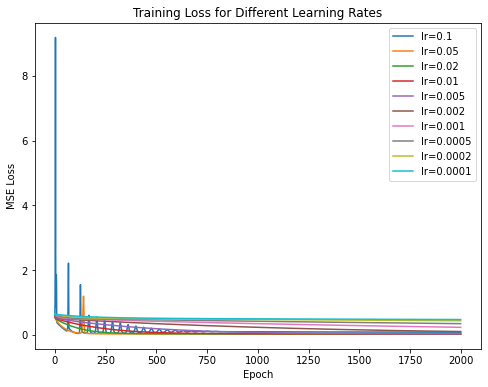

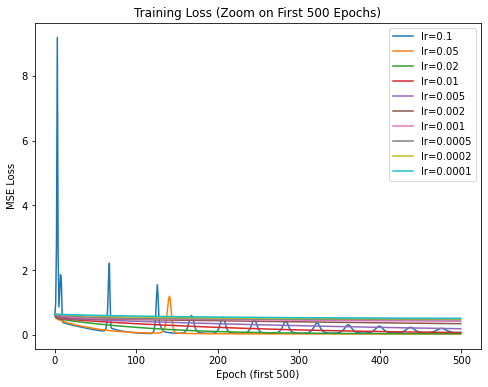

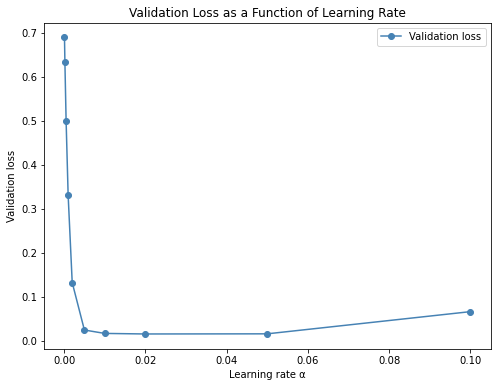

Optimal learning rate: 0.0200


In [106]:
def plot_lr_analysis(results):
    colors = plt.cm.tab10(np.linspace(0, 1, len(results)))

    # ----------------------------------------------------------
    # 1. Training loss vs epoch for different learning rates
    # ----------------------------------------------------------
    plt.figure(figsize=(8,6))
    for r, c in zip(results, colors):
        plt.plot(r["losses"], label=f"lr={r['lr']}", color=c)
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title("Training Loss for Different Learning Rates")
    plt.legend()
    plt.show()

    # ----------------------------------------------------------
    # 2. Zoom on the first 500 epochs (training loss)
    # ----------------------------------------------------------
    plt.figure(figsize=(8,6))
    for r, c in zip(results, colors):
        plt.plot(r["losses"][:500], label=f"lr={r['lr']}", color=c)
    plt.xlabel("Epoch (first 500)")
    plt.ylabel("MSE Loss")
    plt.title("Training Loss (Zoom on First 500 Epochs)")
    plt.legend()
    plt.show()

    # ----------------------------------------------------------
    # 3. Validation loss vs learning rate (linear scale)
    # ----------------------------------------------------------
    lrs = [r["lr"] for r in results]
    val_losses = [r["final_val_loss"] for r in results]

    plt.figure(figsize=(8,6))
    plt.plot(lrs, val_losses, marker="o", color="steelblue", label="Validation loss")
    plt.xlabel("Learning rate α")
    plt.ylabel("Validation loss")
    plt.title("Validation Loss as a Function of Learning Rate")
    plt.legend()
    plt.show()

    # ----------------------------------------------------------
    # 4. Print optimal learning rate
    # ----------------------------------------------------------
    best = min(results, key=lambda r: r["final_val_loss"])
    print(f"Optimal learning rate: {best['lr']:.4f}")

plot_lr_analysis(results)


---


The predictive capability of our  retained model, quantitatively assessed through the MSE values, is further highlighted visually by comparing the true data and the model predictions on both the training and validation sets.

---

**Predictive capacity visualisation**

---

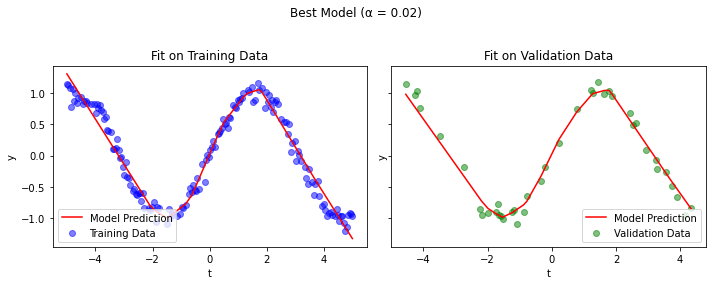

Best lr: 0.0200 | Train loss: 0.020840 | Val loss: 0.015217


In [107]:
def plot_best_model_fit(results):
    best = min(results, key=lambda r: r["final_val_loss"])
    model, lr = best["model"], best["lr"]

    sets = [
        ("Training", best["t_train"], best["y_train"], "blue"),
        ("Validation", best["t_val"], best["y_val"], "green")
    ]

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
    for ax, (name, t, y, color) in zip(axes, sets):
        t_sorted, idx = torch.sort(t.squeeze())
        with torch.no_grad():
            y_pred = model(t_sorted.unsqueeze(1))
        ax.scatter(t_sorted, y[idx], color=color, alpha=0.5, label=f"{name} Data")
        ax.plot(t_sorted, y_pred, color="red", label="Model Prediction")
        ax.set_title(f"Fit on {name} Data")
        ax.set_xlabel("t")
        ax.set_ylabel("y")
        ax.legend()

    fig.suptitle(f"Best Model (α = {lr})", fontsize=12)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    print(f"Best lr: {lr:.4f} | Train loss: {best['final_train_loss']:.6f} | Val loss: {best['final_val_loss']:.6f}")

plot_best_model_fit(results)

The model accurately captures the sinusoidal trend of the data on both the training and validation sets. The close alignment between the predicted (red curve) and true values  (validation set) indicates good generalization and confirms that the model has learned the underlying function without overfitting.

---

---

#### II.2 Scaling law for the optimal learning rate

---

Let's repeat the experiment for several values of the hidden layer size \( d \)
and propose a **scaling law** for the best stepsize
as a function of \( d \):

$
\alpha(d) \approx \nu \, d^{\gamma}
$

where $( \nu )$ and $( \gamma)$ will be determined **numerically**.


---

##### Justification of the approach adopted

---

To identify the parameters $\nu$ and $\gamma$ of the proposed scaling law, the **first natural approach we considered** was to find the pair $(\nu, \gamma)$ that minimizes the objective function:  


$$
J(\nu, \gamma) = \frac{1}{n} \sum_{i=1}^{n} [\alpha^*(d_i) - \nu\, d_i^{\gamma}]^2
$$

This formulation **has no analytical solution**, and therefore requires the use of **numerical optimization methods** (such as gradient descent...).  
However, even in this case, the task remains challenging since the cost function is **non-convex** in $(\nu, \gamma)$.  
Furthermore, this approach would require selecting an appropriate **iteration step size**, which would be paradoxical since the **very core of the exercise lies precisely in determining the step size itself**. This would amount to **chasing our own tail**.  

To avoid this difficulty, we adopt a second strategy that consists of **linearizing** the relationship through a logarithmic transformation:  

$$
\log \alpha^*(d) = \log \nu + \gamma \log d + \varepsilon
$$

This transformation reformulates the problem as a simple **linear model**, which can be solved analytically using **ordinary least squares regression**.  
Nevertheless, this approach has a limitation: the error term $\varepsilon$ is **not necessarily centered** after transformation, since taking logarithms alters the noise distribution. This constitutes a **partial violation of the classical assumptions** of the linear model.  
Despite this limitation, we consider it the **most reasonable and pragmatic compromise** for estimating the parameters $\nu$ and $\gamma$.


---

##### Implementation

---

In [108]:
# =====================================================
# Step 1 — Determine the best learning rate α*(d) for each d
# =====================================================

def find_best_lr_per_d(d_values, lr_grid, n=200, display_perf = False, n_epochs=2000, seed=0):
    best_alphas = []

    for d in d_values:
        print(f"\n=== Searching best learning rate for d = {d} ===")
        results, best = evaluate_learning_rates(
            lr_grid=lr_grid,
            display_perf = display_perf,
            n=n,
            d=d,
            n_epochs=n_epochs,
            seed=seed,
            val_size=0.2,
            target_loss=0.3,
            stability_param=100
        )
        best_alphas.append(best["lr"])
        print(f"Best α*(d={d}) = {best['lr']:.5f}")

    return np.array(d_values), np.array(best_alphas)

# =====================================================
# Step 2 — Fit scaling law: log α* = log ν + γ log d
# =====================================================

def fit_scaling_law(d_values, alphas):
    log_d = np.log(d_values).reshape(-1, 1)
    log_alpha = np.log(alphas)

    model = LinearRegression()
    model.fit(log_d, log_alpha)

    gamma = model.coef_[0]
    log_nu = model.intercept_
    nu = np.exp(log_nu)

    print(f"\nEstimated parameters:")
    print(f"  ν = {nu:.6f}")
    print(f"  γ = {gamma:.6f}")

    return nu, gamma, model


d_values = [ 2, 8, 16, 32, 64]
d_vals, best_alphas = find_best_lr_per_d(d_values, lr_grid)
nu, gamma, model = fit_scaling_law(d_vals, best_alphas)




=== Searching best learning rate for d = 2 ===
                                            === LEARNING RATE EVALUATION ===                                            

                                         
=== BEST LEARNING RATE SELECTION ===                                          
Best lr = 0.05 | ValLoss=0.491311 | TrainLoss=0.404082 | Epochs_speed_30%=2000 | Stability=0.000000
Best α*(d=2) = 0.05000

=== Searching best learning rate for d = 8 ===
                                            === LEARNING RATE EVALUATION ===                                            

                                         
=== BEST LEARNING RATE SELECTION ===                                          
Best lr = 0.05 | ValLoss=0.014248 | TrainLoss=0.020353 | Epochs_speed_30%=63 | Stability=0.000017
Best α*(d=8) = 0.05000

=== Searching best learning rate for d = 16 ===
                                            === LEARNING RATE EVALUATION ===                                            

   

---

#####  Interpretation and Analysis of the Results

---

The experiments conducted allowed us to estimate the scaling law linking the optimal learning rate to the hidden-layer size:

$$
\alpha^*(d) \approx \nu \, d^{\gamma}, \quad
\nu \approx 0.087, \ \gamma \approx -0.47.
$$

The negative value of $\gamma$ indicates that the **optimal learning rate decreases as the network size $d$ increases**.  
This trend can be explained by several complementary factors related to the structure of the optimization problem:

---

- **Increasing model complexity**:  
  As $d$ grows, the number of parameters to optimize increases, expanding the parameter space.  
  This leads to a situation known as the **curse of dimensionality**, where the loss surface becomes **possibly ill-conditioned**, making gradient-based optimization harder to stabilize.

- **Non-convex nature of the objective function**:  
  Our learning problem here is inherently **non-convex** due to the ReLU activation and parameter interactions.  
  The loss surface therefore contains multiple **local minima**, **saddle points**, and regions of **high curvature**.  
  As $d$ increases, these effects become more pronounced, making the optimization process more sensitive to the choice of learning rate.

- **Practical consequence**:  
  
  In such irregular loss landscapes, gradients can fluctuate strongly and point in inconsistent directions, sometimes taking **large magnitudes**.  
  Combined with a large learning rate, this can produce **strong oscillations** in the updates, **slowing down convergence** or even causing **divergence**.  
  As a consequence, a smaller step size helps maintain a more **stable and controlled convergence**, which explains the observed empirical relationship:  
  $$
  \alpha^*(d) \propto d^{\gamma}, \quad \gamma < 0.
  $$


---

In summary, the decrease of the optimal learning rate with network size can be interpreted as a **natural stabilization mechanism** of gradient-based learning in higher-dimensional, non-convex parameter spaces.  
This behavior is consistent with theoretical expectations for gradient descent and common empirical practices in deep learning.

---

##### Empirical validation of the scaled relation

---

Having estimated the parameters $\nu$ and $\gamma$, we now aim to **empirically assess** the plausibility of the obtained relationship.  
In our case, besides assuming that the error terms have zero expectation, we only have five data points, which prevents performing any **reliable statistical tests**.

We therefore select a set of new values of $d$, different from those used for parameter estimation, and train the corresponding models using the learning rates predicted by **our relationship**.

We then examine the **loss curves over epochs** to asses the stability of the fitted models and the **results on the training and validation sets** to evaluate the predictive and generalizing capacities of the obtained model.


---


---

In [109]:
def validate_scaling_relation(nu, gamma, d_test_values, n_epochs=2000, seed=0, val_size=0.2):
    results = []

    # ----------------------------------------------------------
    # Train models for each value of d
    # ----------------------------------------------------------
    for d in d_test_values:
        lr_pred = nu * (d ** gamma)
        print(f"\n=== d = {d} | lr = {lr_pred:.6f} ===")

        model, t_train, t_test, y_train, y_test, losses, _, _, _ = train_model(
            d=d, lr=lr_pred, n_epochs=n_epochs, seed=seed,
            val_size=val_size, target_loss=0.3, stability_param=100
        )

        results.append({
            "d": d, "lr": lr_pred, "model": model,
            "t_train": t_train, "y_train": y_train,
            "t_test": t_test, "y_test": y_test,
            "losses": losses
        })

    # ----------------------------------------------------------
    # Training loss curves
    # ----------------------------------------------------------
    plt.figure(figsize=(10, 6))
    for r in results:
        plt.plot(r["losses"], label=f"d={r['d']}")
    plt.xlabel("Epoch")
    plt.ylabel("Training Loss (MSE)")
    plt.title("Training Loss Curves for Predicted Learning Rates")
    plt.legend()
    plt.grid(True)
    plt.show()

    # ----------------------------------------------------------
    # Visualisation of predictions on train and test sets
    # ----------------------------------------------------------
    for r in results:
        model = r["model"]
        with torch.no_grad():
            y_pred_train = model(r["t_train"])
            y_pred_test = model(r["t_test"])

        fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
        data = [
            ("Training", r["t_train"], r["y_train"], y_pred_train, "blue"),
            ("Test", r["t_test"], r["y_test"], y_pred_test, "orange")
        ]

        for ax, (title, t, y, y_pred, color) in zip(axes, data):
            idx = torch.argsort(t.squeeze())
            ax.scatter(t[idx], y[idx], color=color, alpha=0.5, label=f"{title} data")
            ax.plot(t[idx], y_pred[idx], color="red", label="Model prediction")
            ax.set_title(f"{title} set (d={r['d']}, lr={r['lr']:.4f})")
            ax.set_xlabel("t")
            ax.set_ylabel("y")
            ax.legend()
            ax.grid(True)

        plt.suptitle(f"Model Fit for d={r['d']} (Predicted lr={r['lr']:.4f})", fontsize=12)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

    return results



=== d = 10 | lr = 0.029354 ===

=== d = 50 | lr = 0.013773 ===

=== d = 100 | lr = 0.009942 ===


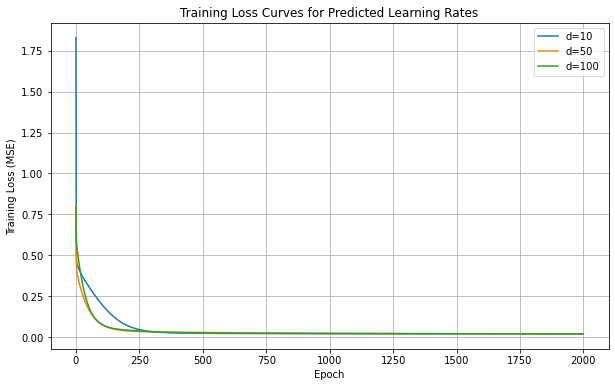

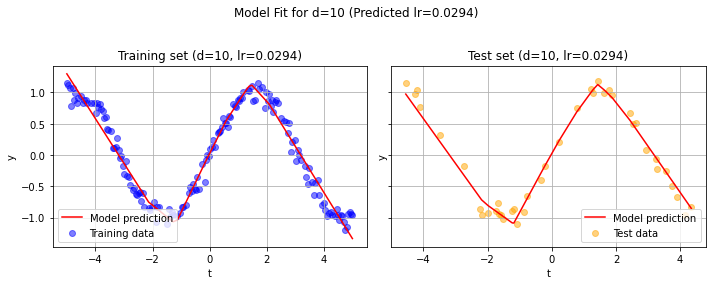

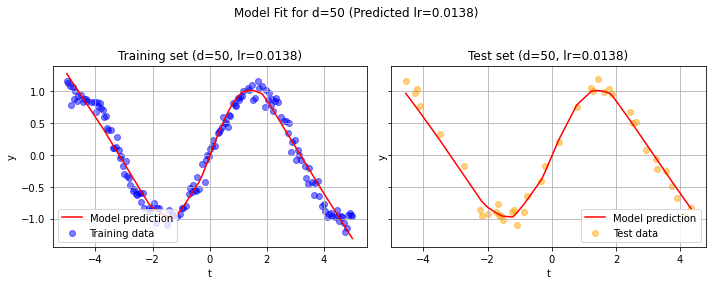

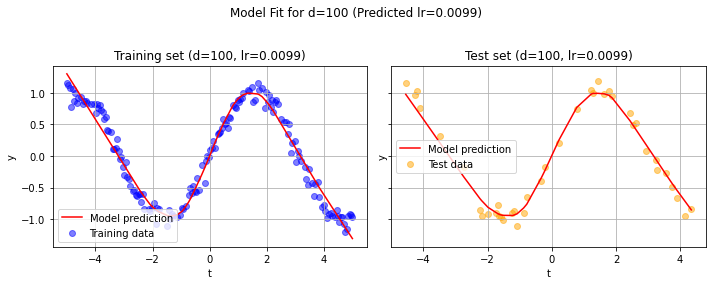

In [110]:

d_test_values = [10, 50,100]
results = validate_scaling_relation(nu, gamma, d_test_values)

---




For each model dimension $d$, the learning rate predicted by the scaling law
$
\alpha(d) \approx \nu \, d^{\gamma}
$
was used to train the model.
The training loss curves show smooth convergence for all tested values of $d$,
while the train/test fits demonstrate that the models trained with the predicted
learning rates reach comparable accuracy and stability, supporting the validity
of the proposed scaling relation.

---

---

##### Summary of the exercise

This exercise was carried out in an academic setting.
The main lesson we draw from it is that, in high-dimensional settings,
gradient descent algorithms tend to be more cautious in choosing the learning rate,
especially when the objective function is irregular,
in order to avoid oscillations and ensure more stable convergence.

It is also important to note that the relationship we found is obviously
not optimal, mainly because of the limitations arising from the assumptions made in our case.
It however provides an order of magnitude for a relevant learning rate to use.
Even then, this relationship is likely valid only under the specific conditions of our experiment —
in particular, the initialization setup, the dataset used, and the sample size.

---
